In [1]:
# Ensure the project root is in the Python path
import sys
sys.path.append('/Users/tl759k/Documents/GitHub/work/cursor-analytics')

# Activate the virtual environment (if not already activated)
# This is typically done outside the notebook, but we ensure the path is correct here
import os
os.system('source /Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/bin/activate')

# Re-import the SnowflakeHook after ensuring the path is set
from utils.snowflake_connection import SnowflakeHook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
import seaborn as sns
import statsmodels.formula.api as smf
from decimal import Decimal
import plotly.express as px


# Create the Snowflake connection hook once
snowhook = SnowflakeHook()

# Function for queries
def load_query(file_path):
    with open(file_path, 'r') as file:
        query = file.read()
    df = snowhook.query_snowflake(query, method='pandas')

    # format Decimal -> float
    for col in df.columns:
        if df[col].dtype == 'object' and isinstance(df[col].dropna().iloc[0], Decimal):
            df[col] = df[col].astype(float)
    return df


2025-09-16 13:55:59,381 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-09-16 13:55:59,381 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as pe
# import plotly.graph_objects as go
import seaborn as sns
import statsmodels.formula.api as smf
from decimal import Decimal

In [4]:
def _r2_fast(y, yhat):
    """Fast R² on numpy arrays (returns -inf if y is constant)."""
    ss_tot = np.square(y - y.mean()).sum()
    if ss_tot == 0:
        return -np.inf
    ss_res = np.square(y - yhat).sum()
    return 1 - ss_res / ss_tot


def _pick_scale_sat_exp(x, y, grid=None):
    """Grid-search the saturating-exponential *scale* that maximises OLS R²."""
    x = x.astype(float)
    y = y.astype(float)

    if grid is None:
        x_pos = x[x > 0]
        x_max = x_pos.max()
        x_med = np.median(x_pos)
        s_min = 1.0 / (10 * x_max)
        s_max = 10.0 / x_med
        grid = np.geomspace(s_min, s_max, 25)

    best_s, best_r2 = None, -np.inf
    for s in grid:
        tr = 1.0 - np.exp(-s * x)
        X = np.vstack([np.ones_like(tr), tr]).T
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
        r2 = _r2_fast(y, X @ beta)
        if r2 > best_r2:
            best_r2, best_s = r2, s

    return best_s if best_s is not None else 1.0


# ---------- Regression runner ----------

def run_regression(df, y, x, *, kind="linear", weights=None, bin_column=None, **kwargs):
    """Fit one curve shape via GLM and return summary, prediction df, and coefficients."""
    work = df.copy()

    if kind == "linear":
        reg = x
        formula = f"{y} ~ {reg}"

    elif kind == "log":
        work["_log_x"] = np.log(work[x].replace(0, np.nan))
        reg = "_log_x"
        formula = f"{y} ~ {reg}"

    elif kind == "log_shift":
        shift = kwargs.get("shift", 1.0)
        work["_log_xs"] = np.log(work[x] + shift)
        reg = "_log_xs"
        formula = f"{y} ~ {reg}"

    elif kind == "exp":
        scale = kwargs.get("scale")
        if scale is None:
            xmax = np.nanmax(work[x].values)
            scale = xmax / 10 if xmax > 0 else 1.0
            print(f"[run_regression] Auto-selected scale={scale:.4g} for exp")
        work["_exp_x"] = np.exp(work[x] / scale)
        reg = "_exp_x"
        formula = f"{y} ~ {reg}"

    elif kind == "power":
        p = kwargs.get("p", 2.0)
        work["_pow_x"] = np.power(work[x], p)
        reg = "_pow_x"
        formula = f"{y} ~ {reg}"

    elif kind == "quadratic":
        work["_x2"] = np.square(work[x])
        reg = ["_x2", x]
        formula = f"{y} ~ {x} + _x2"

    elif kind == "sat_exp":
        scale = kwargs.get("scale")
        if scale is None:
            finite_mask = np.isfinite(work[[x, y]]).all(axis=1)
            scale = _pick_scale_sat_exp(work.loc[finite_mask, x].values,
                                        work.loc[finite_mask, y].values)
            print(f"[run_regression] Auto-selected scale={scale:.4g} for sat_exp")
        work["_sat_x"] = 1.0 - np.exp(-scale * work[x])
        reg = "_sat_x"
        formula = f"{y} ~ {reg}"

    elif kind == "hill":
        h = kwargs.get("h", 1.0)
        k_param = kwargs.get("k", 1.0)
        work["_hill_x"] = (work[x] ** h) / (k_param ** h + work[x] ** h)
        reg = "_hill_x"
        formula = f"{y} ~ {reg}"

    else:
        raise ValueError("Unsupported kind: " + kind)

    # Clean rows
    mask = np.isfinite(work[[y] + ([reg] if isinstance(reg, str) else reg)]).all(axis=1)
    if (d := len(work) - mask.sum()) > 0:
        print(f"[run_regression] Dropped {d} non-finite rows for '{kind}'.")
    work = work.loc[mask]
    if len(work) < 3:
        raise ValueError(f"Not enough observations for kind='{kind}'.")

    # Fit model
    model = smf.glm(formula=formula, data=work,
                    var_weights=weights.loc[work.index] if weights is not None else None).fit()
    params = model.params

    # Pretty formulas
    if kind == "linear":
        fstr = f"{y} = {params[x]:.10f}·{x} + {params['Intercept']:.10f}"
    elif kind == "log":
        fstr = f"{y} = {params['_log_x']:.10f}·ln({x}) + {params['Intercept']:.10f}"
    elif kind == "log_shift":
        fstr = f"{y} = {params['_log_xs']:.10f}·ln({x} + {shift}) + {params['Intercept']:.10f}"
    elif kind == "exp":
        fstr = f"{y} = {params['_exp_x']:.10f}·exp({x}/{scale:.3g}) + {params['Intercept']:.10f}"
    elif kind == "power":
        fstr = f"{y} = {params['_pow_x']:.10f}·({x}^{p}) + {params['Intercept']:.10f}"
    elif kind == "quadratic":
        fstr = f"{y} = {params['_x2']:.10f}·{x}² + {params[x]:.3f}·{x} + {params['Intercept']:.10f}"
    elif kind == "sat_exp":
        fstr = f"{y} = {params['_sat_x']:.10f}·(1 − exp(−{scale:.3g}·{x})) + {params['Intercept']:.10f}"
    else:  # hill
        h = kwargs.get("h", 1.0); k_param = kwargs.get("k", 1.0)
        fstr = f"{y} = {params['_hill_x']:.10f}·({x}^{h})/({k_param}^{h} + {x}^{h}) + {params['Intercept']:.10f}"

    # Pseudo R² fallback
    r2 = getattr(model, "prsquared", 1 - model.deviance / model.null_deviance)

    # Predictions
    x_fit = np.linspace(df[x].min(), df[x].max(), 500)
    pred_df = pd.DataFrame({x: x_fit})

    if kind == "linear":
        pass
    elif kind == "log":
        pred_df["_log_x"] = np.log(pred_df[x])
    elif kind == "log_shift":
        pred_df["_log_xs"] = np.log(pred_df[x] + shift)
    elif kind == "exp":
        pred_df["_exp_x"] = np.exp(pred_df[x] / scale)
    elif kind == "power":
        pred_df["_pow_x"] = np.power(pred_df[x], p)
    elif kind == "quadratic":
        pred_df["_x2"] = np.square(pred_df[x])
    elif kind == "sat_exp":
        pred_df["_sat_x"] = 1.0 - np.exp(-scale * pred_df[x])
    else:  # hill
        pred_df["_hill_x"] = (pred_df[x] ** h) / (k_param ** h + pred_df[x] ** h)

    y_fit = model.predict(pred_df)
    pred_df[y] = y_fit


    # Build summary with normalized coefficient names
    coef_dict = params.to_dict()
    if x in coef_dict:  # rename the main predictor to "x_col"
        coef_dict["x_col"] = coef_dict.pop(x)

    summary = pd.DataFrame({
        "kind": [kind],
        "formula": [fstr],
        "r2": [round(r2, 4)],
        **{coef: [val] for coef, val in coef_dict.items()}
    })


    # Plot
    import seaborn as sns
    plt.figure(figsize=(7, 4))
    if bin_column and bin_column in df.columns:
        unique_bins = df[bin_column].dropna().unique()
        palette = sns.color_palette("tab10", len(unique_bins))
        bin_color_map = dict(zip(unique_bins, palette))
        colors = df[bin_column].map(bin_color_map)
        plt.scatter(df[x], df[y], c=colors, alpha=0.5)
        for label, color in bin_color_map.items():
            plt.scatter([], [], c=[color], label=str(label))
    else:
        plt.scatter(df[x], df[y], alpha=0.5, label="Actual")

    plt.plot(x_fit, y_fit, "r-", label=f"{kind} (R²={r2:.3f})")
    plt.title(f"{kind.replace('_', ' ').title()} fit: {y} vs {x}")
    plt.xlabel(x); plt.ylabel(y)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # summary = pd.DataFrame({"metric": [y], "formula": [fstr], "r2": [round(r2, 4)]})

    return summary, pred_df


# ---------- Fit multiple shapes ----------

def fit_all_curves(df, x_col, y_col, *, shapes=None, weights=None, bin_columns=None, **per_shape_kwargs):
    """Fit multiple curve shapes and summarise results.
       Returns: (best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df)
    """
    if shapes is None:
        shapes = SHAPES

    results = []
    fitted_dfs = {}
    summaries = []

    for kind in shapes:
        kw = per_shape_kwargs.get(kind, {})
        try:
            summ, pred_df = run_regression(df, y_col, x_col, kind=kind,
                                           weights=weights, bin_column=bin_columns, **kw)
            results.append((kind, summ.loc[0, "formula"], summ.loc[0, "r2"]))
            fitted_dfs[kind] = pred_df
            summaries.append(summ)
        except Exception as err:
            print(f"[{kind}] FAILED → {err}")
            results.append((kind, None, -np.inf))
            fitted_dfs[kind] = None

    results_df = pd.DataFrame(results, columns=["kind", "formula", "r2"])
    coef_df = pd.concat(summaries, ignore_index=True) if summaries else pd.DataFrame()

    # Pick best model
    best_kind, best_formula, best_r2 = max(results, key=lambda t: t[2])
    if best_formula is not None:
        print(f"\nBest Model → {best_kind}  (R²={best_r2:.4f})")
        best_fit_df = fitted_dfs[best_kind]
    else:
        print("\nNo model fit succeeded.")
        best_fit_df = None

    return best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df



In [5]:
def pred_formula(s, df):

    if df['kind'][0] == "power":
        
        intercept = df['Intercept'][0]
        _pow_x = df['_pow_x'][0]
        
        return (intercept + _pow_x*s**2)

    elif df['kind'][0] == "quadratic":

        intercep = df['Intercept'][0]
        _x2 = df['_x2'][0]
        x_col = df['x_col'][0]
        
        return (intercep + _x2*s**2 + x_col*s)
    
    elif df['kind'][0] == "sat_exp":
        scale = df['scale'][0]
        intercept = df['Intercept'][0]
        beta = df['_sat_x'][0]

        return intercept + beta * (1.0 - np.exp(-scale * s))

    elif df['kind'][0] == "linear":
        intercept = df['Intercept'][0]
        x_col = df['x_col'][0]

        return (intercept + x_col*s)
    
    
    else:
        print("not power or quadratic")
        return None

def inverse_model(y, df):
    kind = df['kind'][0]
    
    if kind == "power":
        a = df['_pow_x'][0]
        c = df['Intercept'][0]
        return np.sqrt((y - c) / a)   # only positive root (fits spend-style use case)
    
    elif kind == "quadratic":
        a = df['_x2'][0]
        b = df['x_col'][0]
        c = df['Intercept'][0] - y    # note: intercept - y

        disc = b**2 - 4*a*c
        if disc < 0:
            return np.nan   # no real roots
        roots = [(-b + np.sqrt(disc)) / (2*a),
                 (-b - np.sqrt(disc)) / (2*a)]
        return roots  # return both roots as a list
    
    elif kind == "sat_exp":
        scale = df['scale'][0]
        intercept = df['Intercept'][0]
        beta = df['_sat_x'][0]

        ratio = (y - intercept) / beta
        if ratio <= 0 or ratio >= 1:
            return np.nan  # outside valid range
        return -np.log(1 - ratio) / scale
    
    else:
        return None

## 1. Plot CPA Curve

In [8]:
# df_hist_cpa = load_query('./historical_cpa.sql')
df_hist_cpa = load_query('./historical_cpa.sql')

2025-09-16 13:56:36,248 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-09-16 13:56:36,249 - utils.snowflake_connection - INFO - Executing query (pandas)


In [9]:
df_hist_cpa.head()

df_hist_cpa['cpa'] = df_hist_cpa['paid_media_spend'] / (df_hist_cpa['paid_media_applicants'] * 0.7) # adjust for incrementality

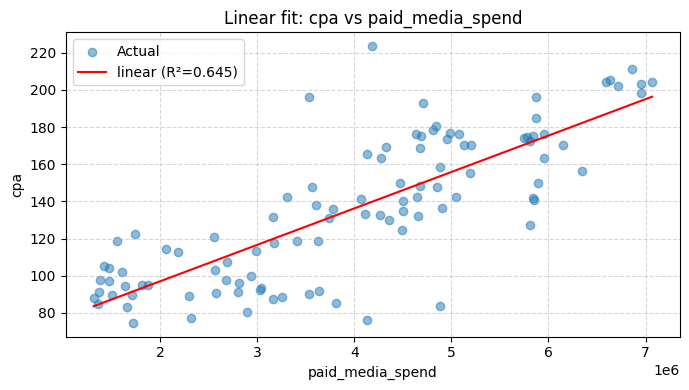


Best Model → linear  (R²=0.6448)


In [10]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["linear"]


df = df_hist_cpa.copy()


# num_bins = 5  
# percentile_cutoff = 0.9

# cost_per_total_applicant
# df['bin'] = pd.qcut(df['paid_media_applicants'], q=num_bins, labels=False, duplicates='drop')
# df['percentile'] = df.groupby('bin')['paid_media_spend'].transform(lambda x: x.rank(pct=True))
# filtered_df = df[df['percentile'] <= percentile_cutoff]
filtered_df = df.copy()
x_col = "paid_media_spend"
y_col = "cpa"


best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df = fit_all_curves(
    filtered_df,
    x_col,
    y_col,
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

# results_df   # summary of all shapes
# print(best_fit_df.head())  # predictions for best model

spend_cpa_coef_df = coef_df
df_spend_cpa = best_fit_df.copy()


In [11]:
spend_cpa_coef_df

,kind,formula,r2,Intercept,x_col
0,linear,cpa = 0.0000196067·paid_media_spend + 57.76047...,0.6448,57.760474,0.00002


In [12]:

spending = np.arange(1000000, 20000001, 1000000)
# spending = np.arange(10000, 100001, 10000)

cpa = pred_formula(spending, spend_cpa_coef_df)

# build dataframe
df_prep = pd.DataFrame({
    "spending": spending,
    "cpa": cpa,
})

df_prep['applicants'] = df_prep['spending'] / df_prep['cpa']

## 2. Calculate DAC Cost Curves - Global Level

### 2.1 DAC Cost Curve (Lifetime or 52w)

In [13]:
df_prep_lifetime = df_prep.copy()

# lifetime cost curve
df_prep_lifetime['new_dx'] = df_prep_lifetime['applicants'] * 0.28 # lifetime conversion rate
df_prep_lifetime['hours'] = df_prep_lifetime['new_dx'] * 170 # lifetime hours (52weeks)
df_prep_lifetime['wad'] = df_prep_lifetime['hours'] / 13 # online hours per dx

# calcualte marginal cost
def calc_marginal_cost(df):
    df['mcpd'] = df['spending'].diff() / df['new_dx'].diff()
    df['mcpwad'] = df['spending'].diff() / df['wad'].diff()
    df['mcpih'] = df['spending'].diff() / df['hours'].diff()
    return df

df_prep_lifetime = calc_marginal_cost(df_prep_lifetime)

df_prep_lifetime_output = df_prep_lifetime[['mcpd', 'mcpwad', 'mcpih']].dropna().reset_index(drop=True)

df_prep_lifetime_output['mcpd_vs_mcpwad'] = df_prep_lifetime_output['mcpd'] / df_prep_lifetime_output['mcpwad']
df_prep_lifetime_output['mcpd_vs_mcpih'] = df_prep_lifetime_output['mcpd'] / df_prep_lifetime_output['mcpih']

df_prep_lifetime_output

,mcpd,mcpwad,mcpih,mcpd_vs_mcpwad,mcpd_vs_mcpih
0,463.897742,35.474533,2.728810,13.076923,170.0
1,699.023131,53.454710,4.111901,13.076923,170.0
2,981.687394,75.070213,5.774632,13.076923,170.0
3,1311.890531,100.321041,7.717003,13.076923,170.0
4,1689.632542,129.207194,9.939015,13.076923,170.0
5,2114.913426,161.728674,12.440667,13.076923,170.0
6,2587.733184,197.885479,15.221960,13.076923,170.0
7,3108.091816,237.677609,18.282893,13.076923,170.0
8,3675.989322,281.105066,21.623467,13.076923,170.0
9,4291.425702,328.167848,25.243681,13.076923,170.0


In [14]:
df_prep_lifetime

,spending,cpa,applicants,new_dx,hours,wad,mcpd,mcpwad,mcpih
0,1000000,77.367143,12925.383501,3619.107380,6.152483e+05,47326.788820,NaN,NaN,NaN
1,2000000,96.973813,20624.124510,5774.754863,9.817083e+05,75516.025131,463.897742,35.474533,2.728810
2,3000000,116.580483,25733.295311,7205.322687,1.224905e+06,94223.450523,699.023131,53.454710,4.111901
3,4000000,136.187153,29371.346071,8223.976900,1.398076e+06,107544.313308,981.687394,75.070213,5.774632
4,5000000,155.793823,32093.698651,8986.235622,1.527660e+06,117512.311984,1311.890531,100.321041,7.717003
5,6000000,175.400493,34207.429586,9578.080284,1.628274e+06,125251.819098,1689.632542,129.207194,9.939015
6,7000000,195.007162,35896.117419,10050.912877,1.708655e+06,131435.014550,2114.913426,161.728674,12.440667
7,8000000,214.613832,37276.255292,10437.351482,1.774350e+06,136488.442452,2587.733184,197.885479,15.221960
8,9000000,234.220502,38425.329638,10759.092299,1.829046e+06,140695.822366,3108.091816,237.677609,18.282893
9,10000000,253.827172,39396.885390,11031.127909,1.875292e+06,144253.211121,3675.989322,281.105066,21.623467


### 2.2 DAC Cost Curve (26w)

In [15]:
new_dx_landing_curve = load_query("new_dx_landing_curve.sql")
new_dx_retention_curve = load_query("new_dx_retention_curve.sql")

2025-09-16 13:57:10,498 - utils.snowflake_connection - INFO - Executing query (pandas)
2025-09-16 13:57:12,410 - utils.snowflake_connection - INFO - Executing query (pandas)


In [16]:
def calc_scenario(spending, applicants, horizon = 26):

    def calc_weekly_converted_dx(new_dx_landing_curve, applicants):
        new_dx_landing_curve['new_dx'] = new_dx_landing_curve['new_dx_ratio'] * applicants
        return new_dx_landing_curve

    df_conv_dx = calc_weekly_converted_dx(new_dx_landing_curve, applicants)    

    hours_per_new_dx = 13.0 # online hours per dx

    df_retained_dx = df_conv_dx.merge(new_dx_retention_curve, how='cross')
    df_retained_dx['wad'] = df_retained_dx['new_dx'] * df_retained_dx['dx_retention']
    
    def keep_first_zero_rest(group):
        first_value = group.iloc[0]  # keep the first row’s original value
        group.iloc[1:] = 0           # set the rest to 0
        group.iloc[0] = first_value
        return group

    df_retained_dx['new_dx'] = df_retained_dx.groupby('horizon_conv')['new_dx'].transform(keep_first_zero_rest)

    df_retained_dx['horizon'] = df_retained_dx['horizon_conv'] + df_retained_dx['horizon_ret']
    df_retained_dx_26w = df_retained_dx[df_retained_dx['horizon'] <= horizon]
    df_retained_dx_26w = df_retained_dx_26w.groupby(['horizon']).agg({'wad': 'sum', 'new_dx': 'sum'}).reset_index(drop = False)
    df_retained_dx_26w['hours'] = df_retained_dx_26w['wad'] * hours_per_new_dx

    df_retained_dx_26w['spending'] = spending
    df_retained_dx_26w['applicants'] = applicants
    df_output = df_retained_dx_26w.groupby(['spending','applicants']).agg({ 'new_dx': 'sum', 'wad': 'sum','hours': 'sum'}).reset_index(drop = False)

    return df_output

In [17]:
def calc_scenario_remove_landing_impact(spending, applicants, horizon=26):

    # Assume all conversions happen at horizon 0, with fixed 28% conversion rate
    converted_dx = applicants * 0.28  

    hours_per_new_dx = 13.0  # online hours per dx

    # Expand with retention curve (assumed pre-defined as new_dx_retention_curve)
    df_retained_dx = new_dx_retention_curve.copy()
    df_retained_dx['new_dx'] = 0
    df_retained_dx.loc[df_retained_dx['horizon_ret'] == 0, 'new_dx'] = converted_dx

    df_retained_dx['wad'] = df_retained_dx['new_dx'] * df_retained_dx['dx_retention']
    df_retained_dx['horizon'] = df_retained_dx['horizon_ret']  # since horizon_conv is 0 for all

    # Keep only horizons up to the cutoff
    df_retained_dx_26w = df_retained_dx[df_retained_dx['horizon'] <= horizon].copy()
    df_retained_dx_26w = df_retained_dx_26w.groupby(['horizon']).agg(
        {'wad': 'sum', 'new_dx': 'sum'}
    ).reset_index(drop=False)

    # Calculate total hours
    df_retained_dx_26w['hours'] = df_retained_dx_26w['wad'] * hours_per_new_dx

    # Add scenario params
    df_retained_dx_26w['spending'] = spending
    df_retained_dx_26w['applicants'] = applicants

    # Aggregate to final output
    df_output = df_retained_dx_26w.groupby(['spending','applicants']).agg({
        'new_dx': 'sum',
        'wad': 'sum',
        'hours': 'sum'
    }).reset_index(drop=False)

    return df_output


In [18]:
df_prep_26w = pd.DataFrame()
for spending in np.arange(1000000, 20000001, 1000000):
# for spending in np.arange(10000, 100001, 10000):
    cpa = pred_formula(spending, spend_cpa_coef_df)
    applicants = spending / cpa
    df_output_tmp = calc_scenario_remove_landing_impact(spending, applicants, horizon = 26)
    df_prep_26w = pd.concat([df_prep_26w, df_output_tmp])

df_prep_26w = calc_marginal_cost(df_prep_26w)
df_prep_26w_output = df_prep_26w[['mcpd', 'mcpwad', 'mcpih']].dropna().reset_index(drop=True)
df_prep_26w_output['mcpd_vs_mcpwad'] = df_prep_26w_output['mcpd'] / df_prep_26w_output['mcpwad']
df_prep_26w_output['mcpd_vs_mcpih'] = df_prep_26w_output['mcpd'] / df_prep_26w_output['mcpih']
df_prep_26w_output

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_26962/1890091900.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3619.107380371971' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_retained_dx.loc[df_retained_dx['horizon_ret'] == 0, 'new_dx'] = converted_dx
/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_26962/1890091900.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5774.754862930308' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_retained_dx.loc[df_retained_dx['horizon_ret'] == 0, 'new_dx'] = converted_dx
/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_26962/1890091900.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '7205.322687070349' ha

,mcpd,mcpwad,mcpih,mcpd_vs_mcpwad,mcpd_vs_mcpih
0,463.897742,463.897742,35.684442,1.0,13.0
1,699.023131,699.023131,53.771010,1.0,13.0
2,981.687394,981.687394,75.514415,1.0,13.0
3,1311.890531,1311.890531,100.914656,1.0,13.0
4,1689.632542,1689.632542,129.971734,1.0,13.0
5,2114.913426,2114.913426,162.685648,1.0,13.0
6,2587.733184,2587.733184,199.056399,1.0,13.0
7,3108.091816,3108.091816,239.083986,1.0,13.0
8,3675.989322,3675.989322,282.768409,1.0,13.0
9,4291.425702,4291.425702,330.109669,1.0,13.0


In [19]:
df_prep_52w = pd.DataFrame()
for spending in np.arange(1000000, 20000001, 1000000):
# for spending in np.arange(10000, 100001, 10000):
    cpa = pred_formula(spending, spend_cpa_coef_df)
    applicants = spending / cpa
    df_output_tmp = calc_scenario_remove_landing_impact(spending, applicants, horizon = 52)
    df_prep_52w = pd.concat([df_prep_52w, df_output_tmp])

df_prep_52w = calc_marginal_cost(df_prep_52w)
df_prep_52w_output = df_prep_52w[['mcpd', 'mcpwad', 'mcpih']].dropna().reset_index(drop=True)
df_prep_52w_output['mcpd_vs_mcpwad'] = df_prep_52w_output['mcpd'] / df_prep_52w_output['mcpwad']
df_prep_52w_output['mcpd_vs_mcpih'] = df_prep_52w_output['mcpd'] / df_prep_52w_output['mcpih']
df_prep_52w_output


/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_26962/1890091900.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3619.107380371971' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_retained_dx.loc[df_retained_dx['horizon_ret'] == 0, 'new_dx'] = converted_dx
/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_26962/1890091900.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5774.754862930308' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_retained_dx.loc[df_retained_dx['horizon_ret'] == 0, 'new_dx'] = converted_dx
/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_26962/1890091900.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '7205.322687070349' ha

,mcpd,mcpwad,mcpih,mcpd_vs_mcpwad,mcpd_vs_mcpih
0,463.897742,463.897742,35.684442,1.0,13.0
1,699.023131,699.023131,53.771010,1.0,13.0
2,981.687394,981.687394,75.514415,1.0,13.0
3,1311.890531,1311.890531,100.914656,1.0,13.0
4,1689.632542,1689.632542,129.971734,1.0,13.0
5,2114.913426,2114.913426,162.685648,1.0,13.0
6,2587.733184,2587.733184,199.056399,1.0,13.0
7,3108.091816,3108.091816,239.083986,1.0,13.0
8,3675.989322,3675.989322,282.768409,1.0,13.0
9,4291.425702,4291.425702,330.109669,1.0,13.0


### 2.3 Global Spending <> mCPD Scenario

df_prep_26w_output: based on new dx conversion and landing curve, actual mCPD <> mCPWAD <> mCPIH

df_prep_lifetime_output: based on lifetime new dx conversion and lifetime hours, actual mCPD <> mCPWAD <> mCPIH

In [20]:
df_sim_output = load_query("all_sms_daco_output.sql")

2025-09-16 14:00:18,694 - utils.snowflake_connection - INFO - Executing query (pandas)


In [21]:
df_sm0 = df_sim_output[df_sim_output['submarket_id'] == 0]

df_sm0_spend_mcpd = df_sm0[['mcpd_scenario', 'spending']]

df_sm0_spend_mcpd

,mcpd_scenario,spending
0,1000,4.669642e+05
1,2000,1.328705e+06
2,3000,2.254686e+06
3,4000,3.036463e+06
4,5000,3.797443e+06
5,6000,4.425450e+06
6,7000,4.965759e+06
7,8000,5.418885e+06
8,9000,5.807385e+06
9,10000,6.118613e+06


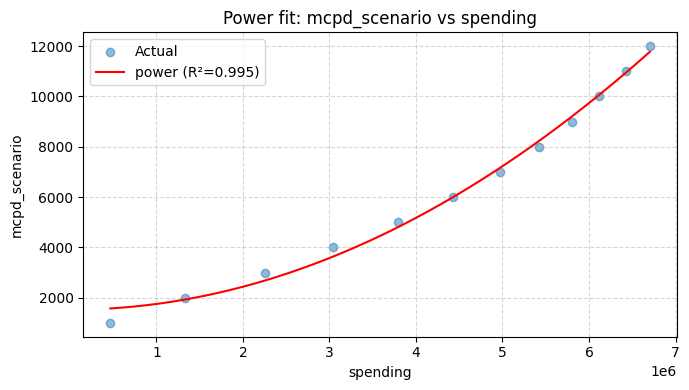


Best Model → power  (R²=0.9945)


In [22]:
# SHAPES = ["linear", "log", "sat_exp", "hill", "exp", "power", "quadratic"]
SHAPES = ["power"]

df_plot = df_sm0_spend_mcpd.copy()
x_col = "spending"
y_col = "mcpd_scenario"


best_kind, best_formula, best_r2, results_df, best_fit_df, coef_df = fit_all_curves(
   df_plot,
    x_col,
    y_col,
    sat_exp=dict(scale=None),
    hill=dict(h=2, k=1000),
    power=dict(p=2.0),
)

In [23]:
spending_mcpd_coef_df = coef_df
df_fit_output = best_fit_df.copy()

df_fit_output = df_fit_output[['spending', 'mcpd_scenario']]
df_fit_output.rename(columns={'mcpd_scenario': 'pred_mcpd'}, inplace=True)

In [24]:
mcpd_vs_mcpwad_26w = df_prep_26w_output['mcpd_vs_mcpwad'].values[0]
mcpd_vs_mcpih_26w = df_prep_26w_output['mcpd_vs_mcpih'].values[0]

mcpd_vs_mcpwad_52w = df_prep_52w_output['mcpd_vs_mcpwad'].values[0]
mcpd_vs_mcpih_52w = df_prep_52w_output['mcpd_vs_mcpih'].values[0]

mcpd_vs_mcpwad_lifetime = df_prep_lifetime_output['mcpd_vs_mcpwad'].values[0]
mcpd_vs_mcpih_lifetime = df_prep_lifetime_output['mcpd_vs_mcpih'].values[0]

mcpd_vs_mcpwad_26w, mcpd_vs_mcpih_26w, mcpd_vs_mcpwad_52w, mcpd_vs_mcpih_52w, mcpd_vs_mcpwad_lifetime, mcpd_vs_mcpih_lifetime


(1.0, 12.999999999999996, 1.0, 12.999999999999996, 13.076923076923078, 170.0)

In [25]:
df_fit_output['pred_mcpwad_26w'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpwad_26w
df_fit_output['pred_mcpih_26w'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpih_26w

df_fit_output['pred_mcpwad_52w'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpwad_52w
df_fit_output['pred_mcpih_52w'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpih_52w

df_fit_output['pred_mcpwad_lifetime'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpwad_lifetime
df_fit_output['pred_mcpih_lifetime'] = df_fit_output['pred_mcpd'] / mcpd_vs_mcpih_lifetime

df_fit_output

,spending,pred_mcpd,pred_mcpwad_26w,pred_mcpih_26w,pred_mcpwad_52w,pred_mcpih_52w,pred_mcpwad_lifetime,pred_mcpih_lifetime
0,4.669642e+05,1573.953340,1573.953340,121.073334,1573.953340,121.073334,120.361138,9.258549
1,4.794638e+05,1576.652157,1576.652157,121.280935,1576.652157,121.280935,120.567518,9.274424
2,4.919633e+05,1579.422261,1579.422261,121.494020,1579.422261,121.494020,120.779349,9.290719
3,5.044629e+05,1582.263652,1582.263652,121.712589,1582.263652,121.712589,120.996632,9.307433
4,5.169624e+05,1585.176330,1585.176330,121.936641,1585.176330,121.936641,121.219366,9.324567
...,...,...,...,...,...,...,...,...
495,6.654245e+06,11625.776316,11625.776316,894.290486,11625.776316,894.290486,889.029954,68.386920
496,6.666745e+06,11663.762212,11663.762212,897.212478,11663.762212,897.212478,891.934757,68.610366
497,6.679245e+06,11701.819396,11701.819396,900.139954,11701.819396,900.139954,894.845013,68.834232
498,6.691744e+06,11739.947866,11739.947866,903.072913,11739.947866,903.072913,897.760719,69.058517


### Plot Global Curve Graph

In [26]:
df_fit_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   spending              500 non-null    float64
 1   pred_mcpd             500 non-null    float64
 2   pred_mcpwad_26w       500 non-null    float64
 3   pred_mcpih_26w        500 non-null    float64
 4   pred_mcpwad_52w       500 non-null    float64
 5   pred_mcpih_52w        500 non-null    float64
 6   pred_mcpwad_lifetime  500 non-null    float64
 7   pred_mcpih_lifetime   500 non-null    float64
dtypes: float64(8)
memory usage: 31.4 KB


In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patheffects as pe
import numpy as np

def plot_mcpwad_curve(df, spending_range=(None, None), mcpd_range=(1000, None), mcpd_step=1000, static_wad=280):
    """
    Plot spending vs. mCPWAD (26wks + lifetime) with markers at every `mcpd_step`,
    plus a horizontal line for static mCPWAD.

    Parameters
    ----------
    df : DataFrame
        Must contain ['spending', 'pred_mcpwad_26w', 'pred_mcpwad_lifetime', 'pred_mcpd']
    spending_range : tuple
        (xmin, xmax) for x-axis in dollars. Use None for auto.
    mcpd_range : tuple
        (min_mcpd, max_mcpd) for annotation ticks in mCPD units. Use None for auto.
    mcpd_step : int
        Step size for mCPD annotations (default=1000).
    static_wad : float
        Reference horizontal line value for mCPWAD.
    """
    # style
    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "font.family": ["Proxima Nova", "Helvetica Neue", "Arial"],
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linestyle": "--",
        "axes.linewidth": 0.8,
    })

    fig, ax = plt.subplots(figsize=(7,4))

    # 1) main lines
    line1, = ax.plot(
        df["spending"], df["pred_mcpwad_26w"],
        label="DAC CPIWAD (26wks)", color="#038c0a", linewidth=1.5, zorder=2
    )
    # line2, = ax.plot(
    #     df["spending"], df["pred_mcpwad_lifetime"],
    #     label="DAC CPIWAD (lifetime)", color="#0778b5", linewidth=1.5, zorder=2
    # )
    line4, = ax.plot(
        df["spending"], df["pred_mcpwad_52w"],
        label="DAC CPIWAD (52wks)", color="#0778b5", linewidth=1.5, zorder=2
    )

    # 2) static reference line
    line3 = ax.axhline(
        y=static_wad, color="red", linestyle=":", linewidth=1.5,
        label=f"BP CPIWAD = {static_wad}"
    )

    # 3) marks every `mcpd_step` in mCPD range
    mcpd_min = mcpd_range[0] if mcpd_range[0] is not None else df["pred_mcpd"].min()
    mcpd_max = mcpd_range[1] if mcpd_range[1] is not None else df["pred_mcpd"].max()
    mcpd_marks = np.arange(mcpd_min, mcpd_max, mcpd_step)

    spending_marks = np.interp(mcpd_marks, df["pred_mcpd"], df["spending"])
    mcpwad26_marks = np.interp(mcpd_marks, df["pred_mcpd"], df["pred_mcpwad_26w"])
    mcpwad52_marks = np.interp(mcpd_marks, df["pred_mcpd"], df["pred_mcpwad_52w"])
    # mcpwadLT_marks = np.interp(mcpd_marks, df["pred_mcpd"], df["pred_mcpwad_lifetime"])

    ax.scatter(spending_marks, mcpwad26_marks, marker='o', s=10, color="#038c0a", zorder=3)
    ax.scatter(spending_marks, mcpwad52_marks, marker='o', s=10, color="#0778b5", zorder=3)
    # ax.scatter(spending_marks, mcpwadLT_marks, marker='o', s=10, color="#0778b5", zorder=3) # s, as square

    # 4) annotate with mCPD labels
    halo = [pe.withStroke(linewidth=2, foreground="white")]
    for s, y, mcpd in zip(spending_marks, mcpwad26_marks, mcpd_marks):
        ax.annotate(f"{int(mcpd/1000)}k", (s, y),
                    xytext=(0,6), textcoords="offset points",
                    ha="center", fontsize=7, color="#038c0a", path_effects=halo)

    for s, y, mcpd in zip(spending_marks, mcpwad52_marks, mcpd_marks):
        ax.annotate(f"{int(mcpd/1000)}k", (s, y),
                    xytext=(0,6), textcoords="offset points",
                    ha="center", fontsize=7, color="#0778b5", path_effects=halo)

    # for s, y, mcpd in zip(spending_marks, mcpwadLT_marks, mcpd_marks):
    #     ax.annotate(f"{int(mcpd/1000)}k", (s, y),
    #                 xytext=(0,-9), textcoords="offset points",
    #                 ha="center", fontsize=7, color="#0778b5", path_effects=halo)

    # 5) formatting
    xmin = spending_range[0] if spending_range[0] is not None else df["spending"].min()
    xmax = spending_range[1] if spending_range[1] is not None else df["spending"].max()
    ax.set_xlim(xmin, xmax)

    ax.set_xlabel("Paid Media Spend")
    ax.set_ylabel("CPIWAD")
    ax.set_title("Global Cost Curve: Spending vs CPIWAD", fontweight="bold", fontsize=10)
    ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))  # commas

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_color("black")

    ax.legend(handles=[line1, line4, line3], fontsize=8, framealpha=0.9, loc="upper left")

    fig.tight_layout()
    plt.show()


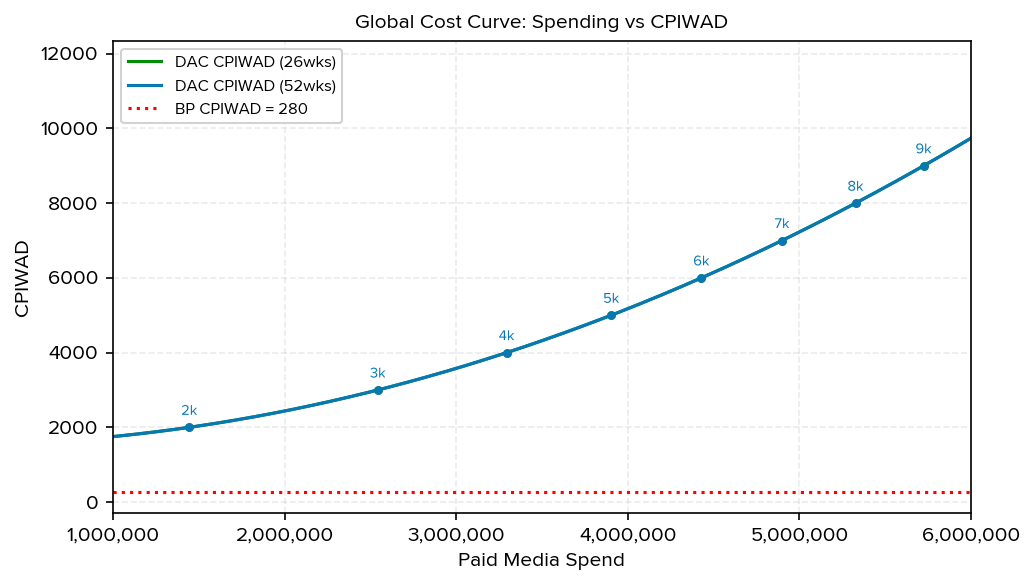

In [29]:
# zoom in: spending 1M–8M, mCPD labels from 2000 to 8000
plot_mcpwad_curve(df_fit_output, spending_range=(1_000_000, 6_000_000), mcpd_range=(1000, 10000), mcpd_step=1000 , static_wad=280)




In [277]:
df_fit_output[(df_fit_output['pred_mcpd'] <= 3100) & (df_fit_output['pred_mcpd'] >= 2900)]

,spending,pred_mcpd,pred_mcpwad_26w,pred_mcpih_26w,pred_mcpwad_lifetime,pred_mcpih_lifetime,pred_mcpwad_52w,pred_mcpih_52w
160,2.466894e+06,2912.535063,377.752632,29.057895,222.723270,17.132559,263.928081,20.302160
161,2.479393e+06,2926.639805,379.582002,29.198616,223.801867,17.215528,265.206225,20.400479
162,2.491893e+06,2940.815833,381.420617,29.340047,224.885917,17.298917,266.490828,20.499294
163,2.504392e+06,2955.063149,383.268479,29.482191,225.975417,17.382724,267.781891,20.598607
164,2.516892e+06,2969.381751,385.125586,29.625045,227.070369,17.466951,269.079414,20.698416
165,2.529391e+06,2983.771641,386.991939,29.768611,228.170773,17.551598,270.383397,20.798723
166,2.541891e+06,2998.232818,388.867538,29.912888,229.276627,17.636664,271.693840,20.899526
167,2.554390e+06,3012.765282,390.752383,30.057876,230.387933,17.722149,273.010742,21.000826
168,2.566890e+06,3027.369032,392.646473,30.203575,231.504691,17.808053,274.334105,21.102623
169,2.579390e+06,3042.044070,394.549810,30.349985,232.626899,17.894377,275.663927,21.204917


### Calculate avg Weekly Applicants and WAD given certain Spend

In [278]:
df_fit_output

,spending,pred_mcpd,pred_mcpwad_26w,pred_mcpih_26w,pred_mcpwad_lifetime,pred_mcpih_lifetime,pred_mcpwad_52w,pred_mcpih_52w
0,4.669642e+05,1573.953340,204.140038,15.703080,120.361138,9.258549,142.628492,10.971422
1,4.794638e+05,1576.652157,204.490071,15.730005,120.567518,9.274424,142.873054,10.990235
2,4.919633e+05,1579.422261,204.849351,15.757642,120.779349,9.290719,143.124075,11.009544
3,5.044629e+05,1582.263652,205.217876,15.785990,120.996632,9.307433,143.381556,11.029350
4,5.169624e+05,1585.176330,205.595647,15.815050,121.219366,9.324567,143.645497,11.049654
...,...,...,...,...,...,...,...,...
495,6.654245e+06,11625.776316,1507.850553,115.988504,889.029954,68.386920,1053.504514,81.038809
496,6.666745e+06,11663.762212,1512.777282,116.367483,891.934757,68.610366,1056.946719,81.303594
497,6.679245e+06,11701.819396,1517.713257,116.747174,894.845013,68.834232,1060.395385,81.568876
498,6.691744e+06,11739.947866,1522.658478,117.127575,897.760719,69.058517,1063.850510,81.834655


In [298]:
def keep_first_zero_rest(group):
    first_value = group.iloc[0]  # keep the first row’s original value
    group.iloc[1:] = 0           # set the rest to 0
    group.iloc[0] = first_value
    return group


def calc_scenario_weekly(spending, applicants):

    def calc_weekly_converted_dx(new_dx_landing_curve, applicants):
        new_dx_landing_curve['new_dx'] = new_dx_landing_curve['new_dx_ratio'] * applicants
        return new_dx_landing_curve

    df_conv_dx = calc_weekly_converted_dx(new_dx_landing_curve, applicants)    

    hours_per_new_dx = 13.0 # online hours per dx

    df_retained_dx = df_conv_dx.merge(new_dx_retention_curve, how='cross')
    df_retained_dx['wad'] = df_retained_dx['new_dx'] * df_retained_dx['dx_retention']
    
    df_retained_dx['new_dx'] = df_retained_dx.groupby('horizon_conv')['new_dx'].transform(keep_first_zero_rest)
    df_retained_dx['hours'] = df_retained_dx['wad'] * hours_per_new_dx

    df_retained_dx['spending'] = spending
    df_retained_dx['applicants'] = applicants
    
    df_output = df_retained_dx[['spending','applicants','horizon_conv','new_dx','horizon_ret','wad','hours']]

    return df_output

In [313]:
spend_list = [5504400, 6076011, 6330060, 2616888, 2888642, 3009421]

results = []
for spending in spend_list:
    cpa = pred_formula(spending, spend_cpa_coef_df)  # your real coef_df goes here
    applicants = spending / cpa
    applicants_adj = applicants / 0.7
    results.append([spending, cpa, applicants, applicants_adj])

# Save results in DataFrame
df_apps_adj = pd.DataFrame(results, columns=["Spending", "CPA", "Applicants", "Applicants_Adj"])

df_apps_adj['cpa_adj'] = df_apps_adj['Spending'] / df_apps_adj['Applicants_Adj']
df_apps_adj


,Spending,CPA,Applicants,Applicants_Adj,cpa_adj
0,5504400,166.119898,33135.103389,47335.861984,116.283929
1,6076011,177.462262,34238.327215,48911.896022,124.223584
2,6330060,182.503306,34684.631920,49549.474171,127.752314
3,2616888,108.823569,24047.070240,34352.957486,76.176498
4,2888642,114.215930,25291.060636,36130.086623,79.951151
5,3009421,116.612523,25807.013803,36867.162576,81.628766


In [ ]:
df_weekly_output = pd.DataFrame()

for spending in spend_list:

    cpa = pred_formula(spending, spend_cpa_coef_df)
    applicants = spending / cpa
    applicants_adj = applicants / 0.7

    for spending_horizon in range(0, 13):

        horizon = spending_horizon 
        df_weekly_output_tmp = calc_scenario(spending, applicants, horizon)
        df_weekly_output_tmp['horizon_spend'] = spending_horizon
        df_weekly_output_tmp['spending'] = df_weekly_output_tmp.groupby('horizon_spend')['spending'].transform(keep_first_zero_rest)
        df_weekly_output_tmp['applicants'] = df_weekly_output_tmp.groupby('horizon_spend')['applicants'].transform(keep_first_zero_rest)
    
        df_weekly_output = pd.concat([df_weekly_output, df_weekly_output_tmp])

df_weekly_output['wad'].mean()

16004.833122094973

In [327]:
spend_list = [5504400, 6076011, 6330060, 2616888, 2888642, 3009421]

df_list = []

for spending in spend_list:
    
    cpa = pred_formula(spending, spend_cpa_coef_df)
    applicants = spending / cpa
    applicants_adj = applicants / 0.7

    for spending_horizon in range(0, 13):
        horizon = spending_horizon

        # calculate scenario (your custom function)
        df_weekly_output_tmp = calc_scenario(spending, applicants_adj, horizon)

        # add metadata columns
        df_weekly_output_tmp['horizon_spend'] = spending_horizon
        df_weekly_output_tmp['spending'] = (
            df_weekly_output_tmp.groupby('horizon_spend')['spending']
            .transform(keep_first_zero_rest)
        )
        df_weekly_output_tmp['applicants'] = (
            df_weekly_output_tmp.groupby('horizon_spend')['applicants']
            .transform(keep_first_zero_rest)
        )

        df_list.append(df_weekly_output_tmp)

# Concatenate once at the end
df_weekly_output = pd.concat(df_list, ignore_index=True)

# Example metric
mean_wad = df_weekly_output['wad'].mean()



In [328]:
df_weekly_output.groupby(['spending', 'applicants']).agg({
    'new_dx': 'mean'
    , 'wad': 'mean'
    , 'hours': 'mean'}).reset_index(drop = False)


,spending,applicants,new_dx,wad,hours
0,2616888,34352.957486,6146.424547,21304.803261,276962.442387
1,2888642,36130.086623,6464.388151,22406.932143,291290.117856
2,3009421,36867.162576,6596.265638,22864.047317,297232.615125
3,5504400,47335.861984,8469.323323,29356.460128,381633.981667
4,6076011,48911.896022,8751.307030,30333.875104,394340.376354
5,6330060,49549.474171,8865.382390,30729.284350,399480.696556
